# Exercício 1
## 3ª Lista de Fundamentos em Redes Neurais e Aprendizagem Estatística
### by Lorran de Araújo Durães Soares

# Imports:

In [41]:
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import cv2

np.random.seed(42) # setando semente

# Pré Processamento

Carregando conjunto de dados:

In [42]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# concatena os dados
x_all = np.concatenate((data_train, data_test), axis=0)
y_all = np.concatenate((label_train, label_test), axis=0)

Filtrando para apenas carros e aviões:

In [43]:
categories = [0, 1]  # airplane, car
train_filter = np.isin(y_all, categories)

x_filt, y_filt = x_all[train_filter.flatten()], y_all[train_filter.flatten()]

Diminuindo o conjunto de dados:

In [44]:
sample_size = 0.1
X_sample, _, y_sample, _ = train_test_split(x_filt, y_filt, test_size=1-sample_size, random_state=42)
print(x_filt.shape)
print(X_sample.shape)

(12000, 32, 32, 3)
(1200, 32, 32, 3)


Plotando imagens de exemplo do banco de imagens:

In [45]:
def plot_images_grid(images, titles, rows=2, cols=4):

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()  # achata o array de eixos para facilitar o acesso

    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


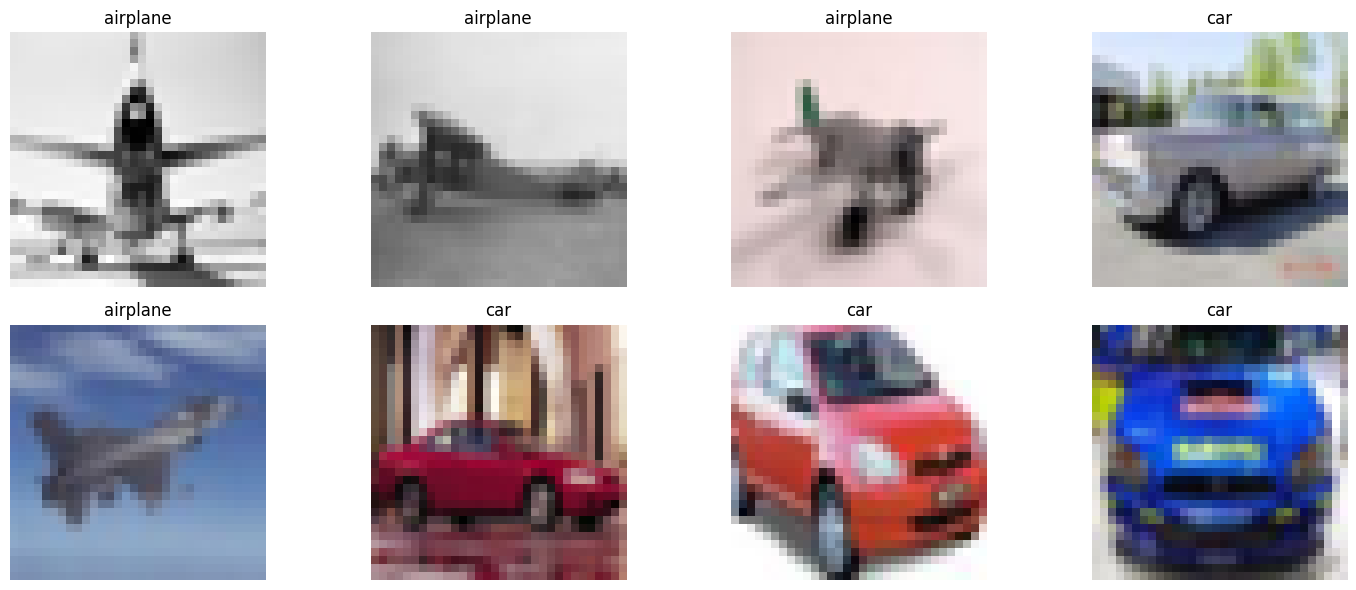

In [46]:
category_labels = {0: 'airplane', 1: 'car'}
num_imagem = 23
list_imgs = []
example_label = []

for i in range(8):
    list_imgs.append(X_sample[num_imagem*i])
    example_label.append(category_labels[y_sample[num_imagem*i][0]])

plot_images_grid(images=list_imgs, titles=example_label)

Convertendo para cinza:

In [47]:
def convert_to_gray(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])
    return gray_images

In [48]:
x_all_gray = convert_to_gray(X_sample)

Vetorizando:

In [49]:
x_all_gray_flattened = x_all_gray.reshape(x_all_gray.shape[0], -1)

Conferindo formato:

In [51]:
print(f'Formato original das imagens: {x_filt.shape[1:]}')
print(f'Formato das imagens após conversão para cinza: {x_all_gray.shape[1:]}')
print(f'Formato das imagens vetorizadas: {x_all_gray_flattened.shape[1]}')

Formato original das imagens: (32, 32, 3)
Formato das imagens após conversão para cinza: (32, 32)
Formato das imagens vetorizadas: 1024


Escalando os dados:

In [52]:
scaler = StandardScaler()
x_sample_scaled = scaler.fit_transform(x_all_gray_flattened)

Dividindo dados em teste e treino, e embaralhando:

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x_sample_scaled, y_sample, test_size=0.3, random_state=42, shuffle=True)

Olhando a distribuição do conjunto de testes:

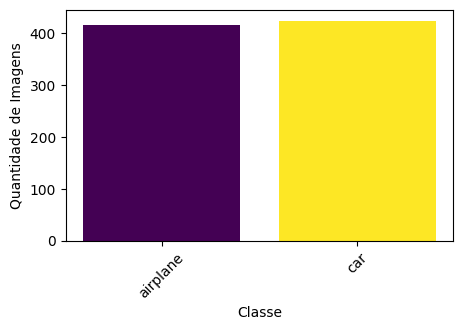

In [54]:
# Conta a quantidade de imagens para cada classe no conjunto de treinamento
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plotar o histograma
class_names = ['airplane', 'car']

colors = plt.cm.viridis(np.linspace(0, 1, len(class_counts)))

plt.figure(figsize=(5, 3))
plt.bar(class_counts.keys(), class_counts.values(), tick_label=class_names, color=colors)
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
#plt.title('Quantidade de Imagens por Classe no Conjunto de Treinamento Fashion')
plt.xticks(rotation=45)
plt.show()

# Letra a):

### Realização do KPCA

Aplicando KPCA:

In [55]:
#kpca = KernelPCA(kernel='poly', gamma=0.1, fit_inverse_transform=True)  # Usando kernel polinomial
kpca = KernelPCA(kernel='poly', fit_inverse_transform=True)
x_train_kpca = kpca.fit_transform(X_train)

Calculando os valores singulares para cálculo da variância explicada:

In [56]:
# Calcular os valores singulares usando SVD
U, S, V = np.linalg.svd(x_train_kpca)

# Variância explicada cumulativa (normalizando pela soma dos valores singulares ao quadrado)
variancia_explicada_cumulativa = np.cumsum(S ** 2 / np.sum(S ** 2))


Plotando gráfico da variância explicada:

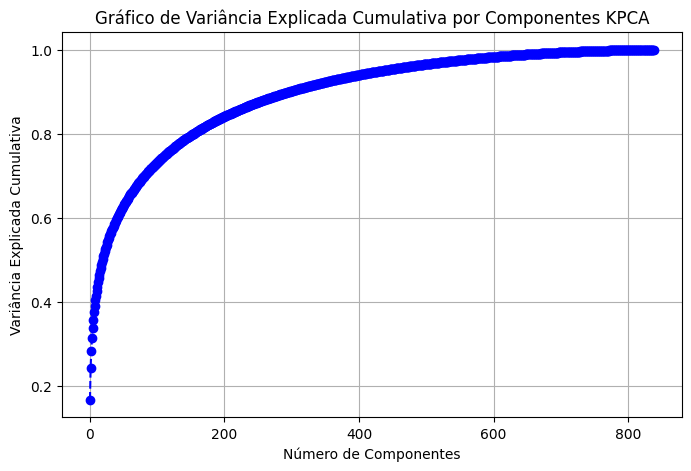

In [57]:
# Plotar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(variancia_explicada_cumulativa, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Gráfico de Variância Explicada Cumulativa por Componentes KPCA')
plt.grid()
plt.show()

Encontrando o número de componentes que explicam 95% da variância:

In [58]:
n_componentes_95 = np.argmax(variancia_explicada_cumulativa >= 0.95) + 1

print(f'Número de componentes que explicam pelo menos 95% da variância: {n_componentes_95}')

Número de componentes que explicam pelo menos 95% da variância: 435


Reduzindo KPCA para número de componentes encontrado:

In [59]:
kpca = KernelPCA(kernel='poly', gamma=0.1, fit_inverse_transform=True, n_components=n_componentes_95)  # Usando kernel polinomial
x_train_kpca = kpca.fit_transform(X_train)

Projetando dados de teste também para a dimnesão reduzida:

In [60]:
X_test_kpca = kpca.transform(X_test)

Plotando o KPCA:

In [61]:
def plot_kpca(x, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), cmap='viridis', s=10)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

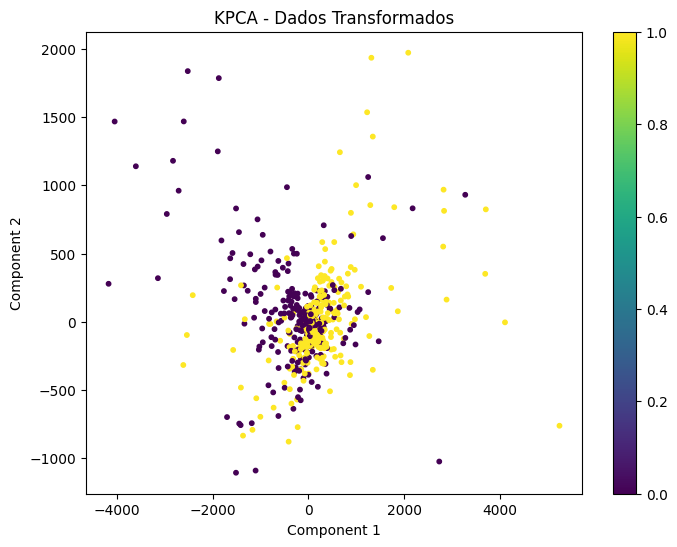

In [62]:
plot_kpca(x_train_kpca, y_train, 'KPCA - Dados Transformados')

### Aplicando SVM linear

Treinando modelo:

In [63]:
kf1 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
svm_linear = []

i = 1

# itera sobre cada fold
for train_index, test_index in kf1.split(x_train_kpca):
    
    X_train2, X_val = x_train_kpca[train_index], x_train_kpca[test_index]
    y_train2, y_val = y_train[train_index], y_train[test_index]
    
    # cria e treinar o modelo SVM
    clf_linear = SVC(kernel='linear', C=1.0)
    clf_linear.fit(X_train2, y_train2.ravel())

    svm_linear.append(clf_linear)
    
    # avalia o modelo no conjunto de validação
    accuracy1 = clf_linear.score(X_val, y_val)
    print(f"Acurácia da validação no fold {i}: {accuracy1:.2f}")

    # avalia o modelo no conjunto de teste
    accuracy2 = clf_linear.score(X_test_kpca, y_test)
    print(f"Acurácia do teste no fold {i}: {accuracy2:.2f}")
    i = i + 1

    print("===============================================")


Acurácia da validação no fold 1: 0.60
Acurácia do teste no fold 1: 0.72
Acurácia da validação no fold 2: 0.69
Acurácia do teste no fold 2: 0.74
Acurácia da validação no fold 3: 0.57
Acurácia do teste no fold 3: 0.71
Acurácia da validação no fold 4: 0.60
Acurácia do teste no fold 4: 0.72


Fazendo experimento. Em duas dimensões para visualizar o SVM:

In [64]:
# realizando redução de dimensionalidade pelo kernel polinomial
kpca_red = KernelPCA(kernel='poly', gamma=0.1, n_components=2)
x_train_kpca_red = kpca_red.fit_transform(X_train)

In [65]:
kf3 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
svm_linear_red = []

# treina svm
for train_index, test_index in kf3.split(x_train_kpca_red):
    
    X_train3, X_val = x_train_kpca_red[train_index], x_train_kpca_red[test_index]
    y_train3, y_val = y_train[train_index], y_train[test_index]
    
    # cria e treinar o modelo SVM
    clf_linear = SVC(kernel='linear', C=1.0)
    clf_linear.fit(X_train3, y_train3.ravel())

    svm_linear_red.append(clf_linear)
    
    # avalia o modelo no conjunto de validação
    accuracy = clf_linear.score(X_val, y_val)
    print(f"Acurácia no fold: {accuracy:.2f}")


Acurácia no fold: 0.62
Acurácia no fold: 0.52
Acurácia no fold: 0.63
Acurácia no fold: 0.67


In [66]:
# plot da reta do svm
def plot_decision_boundary(clf, X, y, title, xmin=None, xmax=None, ymin=None, ymax=None):
    h = 3  # Tamanho do passo da malha
    if (not xmin) or (not xmax) or (not ymin) or (not ymax):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    else:
        x_min, x_max, y_min, y_max = xmin, xmax, ymin, ymax

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='viridis')
    plt.title(title)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.show()

In [67]:
X_test_kpca_red = kpca_red.transform(X_test)

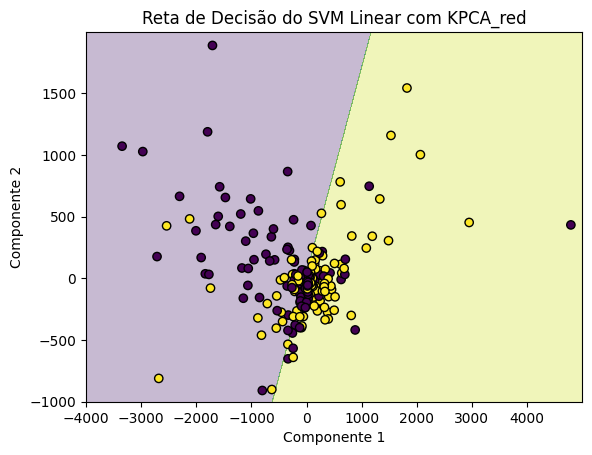

In [68]:
plot_decision_boundary(svm_linear_red[3], X_test_kpca_red, y_test, 'Reta de Decisão do SVM Linear com KPCA_red', -4000, 5000, -1000, 2000)

In [69]:
accuracy = svm_linear_red[3].score(X_test_kpca_red, y_test)
print(f"Acurácia no fold: {accuracy:.2f}")

Acurácia no fold: 0.57


# Letra b):

### Aplicando PCA

Calculando a matriz PCA

In [70]:
pca = PCA()
pca.fit(X_train)

PCA()

Calculando e plotando a variância explicada:

In [71]:
# Variância explicada cumulativa
variancia_explicada_cumulativa = np.cumsum(pca.explained_variance_ratio_)

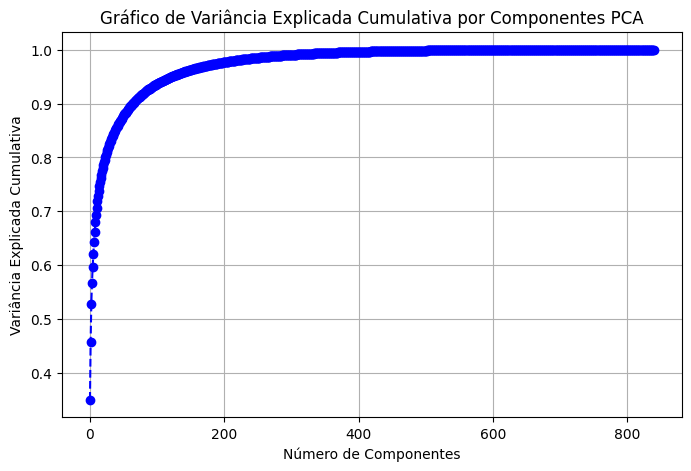

In [72]:
# Plotar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(variancia_explicada_cumulativa, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Gráfico de Variância Explicada Cumulativa por Componentes PCA')
plt.grid()
plt.show()


Obtendo o número de componenetes que explicam pelo menos 95% da variância:

In [73]:
# Calcular a variância explicada cumulativa
variancia_explicada_cumulativa = np.cumsum(pca.explained_variance_ratio_)

# Encontrar o número de componentes que explicam pelo menos 95% da variância
n_componentes_95 = np.argmax(variancia_explicada_cumulativa >= 0.95) + 1

print(f'Número de componentes que explicam pelo menos 95% da variância: {n_componentes_95}')

Número de componentes que explicam pelo menos 95% da variância: 123


Reduzindo o PCA para o número obtido:

In [74]:
pca = PCA(n_components=n_componentes_95)
x_train_pca = pca.fit_transform(X_train)

Aplicando conjunto de testes a base PCA e plotando:

In [75]:
X_test_pca = pca.transform(X_test)

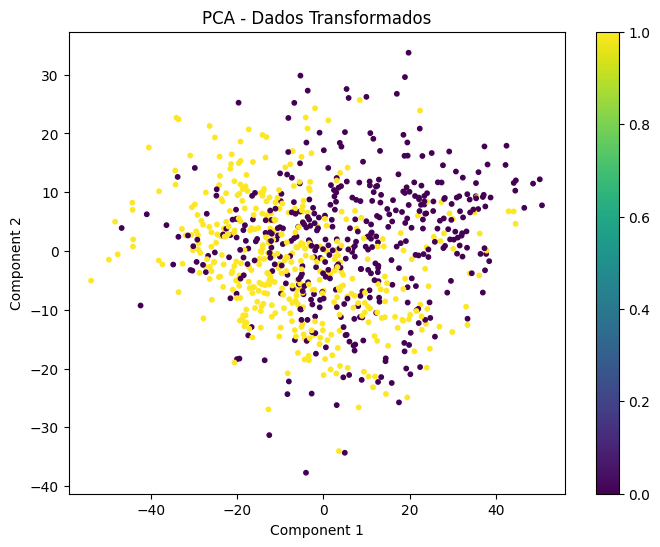

In [76]:
plot_kpca(x_train_pca, y_train, 'PCA - Dados Transformados')

### Aplicando Kernel SVM

In [77]:
kf2 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
svm_kernel = []

kernels = ['rbf', 'poly', 'sigmoid']

# itera sobre cada fold
for ker in kernels:

    i = 1

    print(f"Utilizando o kernel {ker} no SVM:")

    for train_index, test_index in kf2.split(x_train_pca):
        
        X_train4, X_val = x_train_pca[train_index], x_train_pca[test_index]
        y_train4, y_val = y_train[train_index], y_train[test_index]
        
        # cria e treinar o modelo SVM
        clf_kernel = SVC(kernel=ker, C=1.0)
        clf_kernel.fit(X_train4, y_train4.ravel())

        svm_kernel.append(clf_kernel)
        

        print()
        # avalia o modelo no conjunto de validação
        accuracy3 = clf_kernel.score(X_val, y_val)
        print(f"Acurácia da validaçao no fold {i}: {accuracy3:.2f}")
        
        # avalia o modelo no conjunto de teste
        accuracy4 = clf_kernel.score(X_test_pca, y_test)
        print(f"Acurácia do teste no fold {i}: {accuracy4:.2f}")

        print('====================================================')

        i = i + 1
    
    print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-")

Utilizando o kernel rbf no SVM:

Acurácia da validaçao no fold 1: 0.79
Acurácia do teste no fold 1: 0.80

Acurácia da validaçao no fold 2: 0.77
Acurácia do teste no fold 2: 0.80

Acurácia da validaçao no fold 3: 0.76
Acurácia do teste no fold 3: 0.81

Acurácia da validaçao no fold 4: 0.78
Acurácia do teste no fold 4: 0.83
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-
Utilizando o kernel poly no SVM:

Acurácia da validaçao no fold 1: 0.74
Acurácia do teste no fold 1: 0.71

Acurácia da validaçao no fold 2: 0.70
Acurácia do teste no fold 2: 0.75

Acurácia da validaçao no fold 3: 0.73
Acurácia do teste no fold 3: 0.75

Acurácia da validaçao no fold 4: 0.70
Acurácia do teste no fold 4: 0.73
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-
Utilizando o kernel sigmoid no SVM:

Acurácia da validaçao no fold 1: 0.66
Acurácia do teste no fold 1: 0.67

Acurácia da validaçao no fold 2: 0.70
Acurácia do teste no fold 2: 0.70

Acurácia da validaçao no fold 3: 0.69


Experimento: fazendo para duas dimensões

In [94]:
pca_red = PCA(n_components=2)
x_train_pca_red = pca_red.fit_transform(X_train)

In [95]:
kf2 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
svm_kernel_red = []

# itera sobre cada fold
for train_index, test_index in kf2.split(x_train_pca_red):
    
    X_train5, X_val = x_train_pca_red[train_index], x_train_pca_red[test_index]
    y_train5, y_val = y_train[train_index], y_train[test_index]
    
    # cria e treinar o modelo SVM
    clf_kernel = SVC(kernel='rbf', C=1.0)
    clf_kernel.fit(X_train5, y_train5.ravel())

    svm_kernel_red.append(clf_kernel)
    
    # avalia o modelo no conjunto de validação
    accuracy = clf_kernel.score(X_val, y_val)
    print(f"Acurácia no fold: {accuracy:.2f}")


Acurácia no fold: 0.69
Acurácia no fold: 0.61
Acurácia no fold: 0.67
Acurácia no fold: 0.67


In [96]:
scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(X_test)
x_test_pca_red = pca_red.transform(x_test_scaled)

Acurácia no fold: 0.63


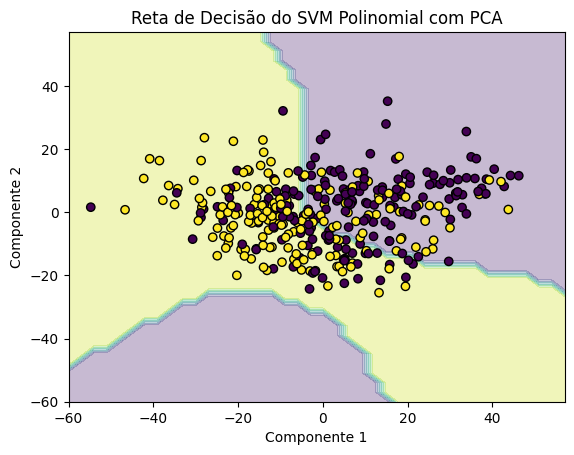

In [97]:
accuracy = svm_kernel_red[3].score(x_test_pca_red, y_test)
print(f"Acurácia no fold: {accuracy:.2f}")
plot_decision_boundary(svm_kernel_red[3], x_test_pca_red, y_test, 'Reta de Decisão do SVM Polinomial com PCA', xmin=-60, xmax=60,ymin=-60, ymax=60)